In [26]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, InputLayer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib as imp
import datacleaner
import datetime
imp.reload(datacleaner)

from datacleaner import *

In [27]:
np.random.seed(1)
tf.keras.backend.clear_session()

bd = pd.read_csv(r"training_data.csv", na_filter=False)

In [28]:
bd.head()

,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain,incidents
0,Guimaraes,UNDEFINED,0,",",2021-03-15 23:00,DARK,12.0,1013.0,70.0,1.0,0.0,Sem Chuva,None
1,Guimaraes,UNDEFINED,385,"N101,",2021-12-25 18:00,DARK,12.0,1007.0,91.0,1.0,0.0,Sem Chuva,None
2,Guimaraes,UNDEFINED,69,",",2021-03-12 15:00,LIGHT,14.0,1025.0,64.0,0.0,0.0,Sem Chuva,Low
3,Guimaraes,MAJOR,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2021-09-29 09:00,LIGHT,15.0,1028.0,75.0,1.0,0.0,Sem Chuva,Very_High
4,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-13 11:00,LIGHT,27.0,1020.0,52.0,1.0,0.0,Sem Chuva,High


In [29]:
def tratar_dados(bd):
    bd = ordernar(bd)
    bd = RoadsCleaner(bd)
    #bd = data(bd)
    bd = valores_em_falta(bd)
    bd = eliminar(bd)
    bd = incidentsNumbers(bd)
    bd = luminosidade(bd)
    bd = rainNumbers(bd)
    bd = delayNumbers(bd)
    bd = removeOutlier(bd)
    indice_treino, indice_val=split_data(bd, perc=10)
    escala, bd = data_normalization(bd, norm_range=(-1, 1))
    return bd,indice_treino,indice_val,escala
    
bd,indice_treino,indice_val,escala=tratar_dados(bd)
bd.head()

c:\Users\Lipe\Desktop\Universidade e coisas minhas\Programming\CSC\datacleaner.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bd['magnitude_of_delay'][i] = None
c:\Users\Lipe\Desktop\Universidade e coisas minhas\Programming\CSC\datacleaner.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bd["delay_in_seconds"][count] = valor


,magnitude_of_delay,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,Estrada Nacional,Estrada Regional,IC,Estrada Municipal,record_date
4255,-1.0,-0.995818,-1.0,-0.470588,0.828571,0.106383,-1.0,-1.0,0.5,-0.952381,-0.333333,-1.0,0,2021-01-16 16:00:00
3965,-1.0,-1.000000,1.0,-0.705882,0.885714,0.851064,-0.8,-1.0,0.0,-1.000000,-0.333333,-1.0,0,2021-01-16 18:00:00
820,-1.0,-1.000000,1.0,-0.705882,0.885714,0.446809,-0.8,-1.0,0.0,-1.000000,-0.333333,-1.0,0,2021-01-16 19:00:00
3245,-1.0,-1.000000,1.0,-0.764706,1.000000,-0.957447,-0.8,-1.0,0.0,-1.000000,-0.333333,-1.0,0,2021-01-16 20:00:00
4671,-1.0,-0.978767,1.0,-0.764706,0.885714,0.553191,-0.8,-1.0,0.5,-1.000000,-0.333333,-1.0,0,2021-01-16 21:00:00


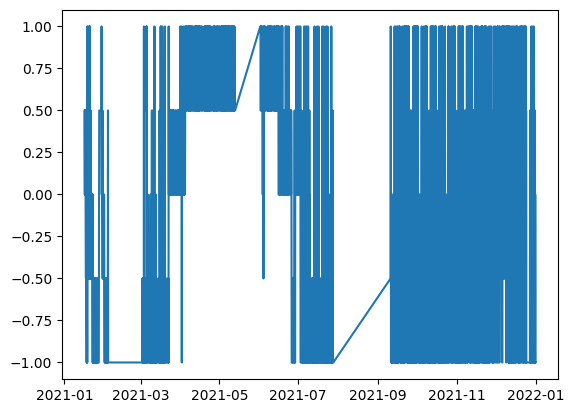

record_date
2021-01-16 16:00:00   2021-01-16 16:00:00
2021-01-16 18:00:00   2021-01-16 18:00:00
2021-01-16 19:00:00   2021-01-16 19:00:00
2021-01-16 20:00:00   2021-01-16 20:00:00
2021-01-16 21:00:00   2021-01-16 21:00:00
                              ...        
2021-12-31 17:00:00   2021-12-31 17:00:00
2021-12-31 18:00:00   2021-12-31 18:00:00
2021-12-31 19:00:00   2021-12-31 19:00:00
2021-12-31 20:00:00   2021-12-31 20:00:00
2021-12-31 23:00:00   2021-12-31 23:00:00
Name: record_date, Length: 5000, dtype: datetime64[ns]

In [30]:
bd.index = pd.to_datetime(bd["record_date"], format="%Y-%m-%d %H:%M:00")
serie(bd,"incidents")
newBd = bd[["incidents","record_date"]]
bd.pop("record_date")

                     magnitude_of_delay  delay_in_seconds  luminosity  \
record_date                                                             
2021-01-16 16:00:00                -1.0         -0.995818        -1.0   
2021-01-16 17:00:00                -1.0         -0.997909         0.0   
2021-01-16 18:00:00                -1.0         -1.000000         1.0   
2021-01-16 19:00:00                -1.0         -1.000000         1.0   
2021-01-16 20:00:00                -1.0         -1.000000         1.0   
...                                 ...               ...         ...   
2021-12-31 19:00:00                -1.0         -0.678281         1.0   
2021-12-31 20:00:00                -1.0         -1.000000         1.0   
2021-12-31 21:00:00                -1.0         -1.000000         1.0   
2021-12-31 22:00:00                -1.0         -1.000000         1.0   
2021-12-31 23:00:00                -1.0         -1.000000         1.0   

                     avg_temperature  avg_atm_pres

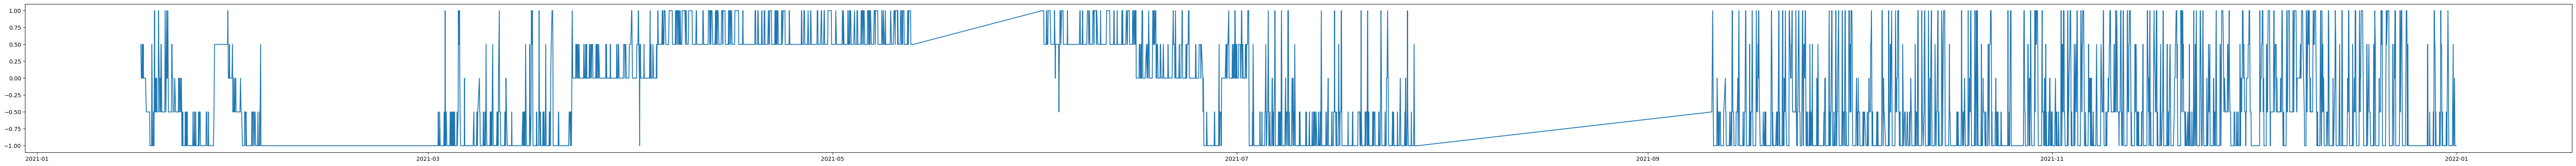

record_date
2021-01-16 16:00:00    0.50
2021-01-16 17:00:00    0.25
2021-01-16 18:00:00    0.00
2021-01-16 19:00:00    0.00
2021-01-16 20:00:00    0.00
                       ... 
2021-12-31 19:00:00   -1.00
2021-12-31 20:00:00   -1.00
2021-12-31 21:00:00   -1.00
2021-12-31 22:00:00   -1.00
2021-12-31 23:00:00   -1.00
Name: incidents, Length: 7640, dtype: float64


In [31]:
temp = bd
temp = temp.resample("H").interpolate(method="time")
temp =temp[temp.index.month !=8]
print(temp)
fig=plt.figure()
plt.plot(temp["incidents"])
spacing =10
fig.subplots_adjust(right=spacing)
plt.show()
print(temp["incidents"])

In [32]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = df_as_np[i:i + window_size]
        X.append(row)
        label = df_as_np[i + window_size][8]  # Última coluna contém a variável de destino (incidentes)
        y.append(label)
    return np.array(X), np.array(y)

In [33]:
WINDOW_SIZE = 48
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((7592, 48, 13), (7592,))

In [34]:
X_train1, y_train1 = X1[:6000], y1[:6000]
X_val1, y_val1 = X1[6000:7000], y1[6000:7000]
X_test1, y_test1 = X1[7000:], y1[7000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((6000, 48, 13), (6000,), (1000, 48, 13), (1000,), (592, 48, 13), (592,))

In [35]:
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [36]:
def build_model(timesteps):
    model = Sequential()
    model.add(InputLayer((48, 13)))
    model.add(SimpleRNN(units=64, input_shape=(timesteps, 1), activation='relu'))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1))
    
    #model summary (and save it as PNG)
    # tf.keras.utils.plot_model(model, 'Kagglernn.png', show_shapes=True)
    return model

In [37]:
model = build_model(timesteps=WINDOW_SIZE)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4992      
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 5,521
Trainable params: 5,521
Non-trainable params: 0
_________________________________________________________________


In [38]:
cp1 = ModelCheckpoint('model_KaggleRNN/model.h5', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [39]:
model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp1])

Epoch 1/100
188/188 [==============================] - 2s 5ms/step - loss: 0.1190 - root_mean_squared_error: 0.3450 - val_loss: 0.2165 - val_root_mean_squared_error: 0.4653
Epoch 2/100
188/188 [==============================] - 1s 4ms/step - loss: 0.0778 - root_mean_squared_error: 0.2789 - val_loss: 0.2196 - val_root_mean_squared_error: 0.4687
Epoch 3/100
188/188 [==============================] - 1s 4ms/step - loss: 0.0738 - root_mean_squared_error: 0.2716 - val_loss: 0.2121 - val_root_mean_squared_error: 0.4605
Epoch 4/100
188/188 [==============================] - 1s 4ms/step - loss: 0.0733 - root_mean_squared_error: 0.2707 - val_loss: 0.1948 - val_root_mean_squared_error: 0.4414
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 0.0706 - root_mean_squared_error: 0.2657 - val_loss: 0.1890 - val_root_mean_squared_error: 0.4348
Epoch 6/100
188/188 [==============================] - 1s 4ms/step - loss: 0.0706 - root_mean_squared_error: 0.2658 - val_loss: 0.1977 

In [40]:
from tensorflow.keras.models import load_model
model = load_model('model_KaggleRNN/model.h5')

In [41]:
train_predictions = model.predict(X_train1).flatten()
escala_predictions = MinMaxScaler()
escala_actuals = MinMaxScaler()

escala_predictions.fit(train_predictions.reshape(-1, 1))
escala_actuals.fit(y_train1.reshape(-1, 1))

train_predictions_unscaled = escala_predictions.inverse_transform(train_predictions.reshape(-1, 1))
y_train1_unscaled = escala_actuals.inverse_transform(y_train1.reshape(-1, 1))
train_predictions_unscaled += 3
y_train1_unscaled += 3
train_results = pd.DataFrame(data={'Train Predictions': train_predictions_unscaled.flatten(), 'Actuals': y_train1_unscaled.flatten()})
train_results

188/188 [==============================] - 0s 2ms/step


,Train Predictions,Actuals
0,0.155626,0.0
1,0.196218,3.0
2,2.589056,4.0
3,2.730083,1.0
4,0.379827,2.0
...,...,...
5995,-0.124245,0.0
5996,-0.121192,0.0
5997,-0.118991,0.0
5998,-0.117343,0.0


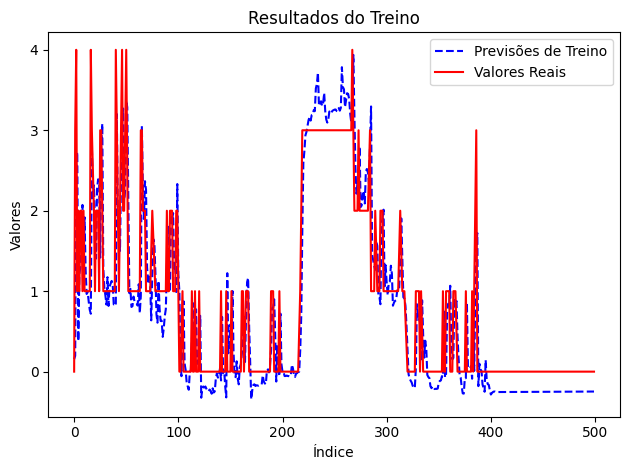

In [42]:
import matplotlib.pyplot as plt
plt.title('Resultados do Treino')
plt.xlabel('Índice')
plt.ylabel('Valores')

plt.plot(train_results['Train Predictions'][:500], color='blue', linestyle='--', label='Previsões de Treino')
plt.plot(train_results['Actuals'][:500], color='red', linestyle='-', label='Valores Reais')

plt.legend()
plt.tight_layout()
plt.show()

In [43]:
val_predictions = model.predict(X_val1).flatten()
escala_predictions = MinMaxScaler()
escala_actuals = MinMaxScaler()

escala_predictions.fit(val_predictions.reshape(-1, 1))
escala_actuals.fit(y_val1.reshape(-1, 1))

val_predictions_unscaled = escala_predictions.inverse_transform(val_predictions.reshape(-1, 1))
y_val1_unscaled = escala_actuals.inverse_transform(y_val1.reshape(-1, 1))
val_predictions_unscaled += 3
y_val1_unscaled += 3
val_results = pd.DataFrame(data={'Val Predictions': val_predictions_unscaled.flatten(), 'Actuals': y_val1_unscaled.flatten()})
val_results

32/32 [==============================] - 0s 2ms/step


,Val Predictions,Actuals
0,0.348929,0.0
1,0.349264,0.0
2,0.349747,0.0
3,0.350282,0.0
4,0.352871,0.0
...,...,...
995,1.193305,1.0
996,1.161985,1.0
997,1.158432,1.0
998,1.152767,1.0


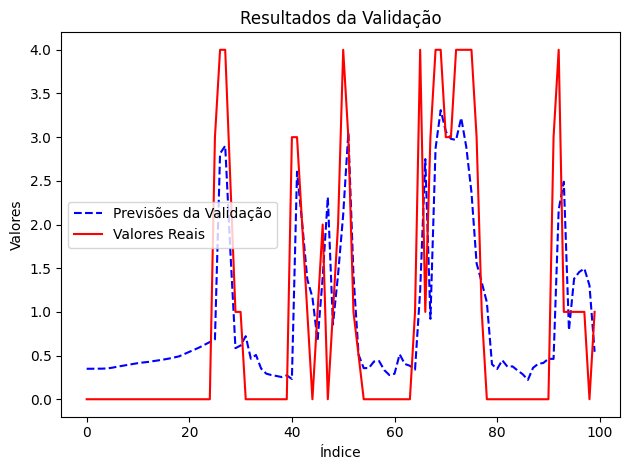

In [44]:
import matplotlib.pyplot as plt

plt.title('Resultados da Validação')
plt.xlabel('Índice')
plt.ylabel('Valores')

plt.plot(val_results['Val Predictions'][:100], color='blue', linestyle='--', label='Previsões da Validação')
plt.plot(val_results['Actuals'][:100], color='red', linestyle='-', label='Valores Reais')

plt.legend()
plt.tight_layout()
plt.show()

In [45]:
test_predictions = model.predict(X_test1).flatten()
escala_predictions = MinMaxScaler()
escala_actuals = MinMaxScaler()

escala_predictions.fit(test_predictions.reshape(-1, 1))
escala_actuals.fit(y_test1.reshape(-1, 1))

test_predictions_unscaled = escala_predictions.inverse_transform(test_predictions.reshape(-1, 1))
y_test1_unscaled = escala_actuals.inverse_transform(y_test1.reshape(-1, 1))
test_predictions_unscaled += 3
y_test1_unscaled += 3
test_results = pd.DataFrame(data={'Test Predictions': test_predictions_unscaled.flatten(), 'Actuals': y_test1_unscaled.flatten()})
test_results

19/19 [==============================] - 0s 2ms/step


,Test Predictions,Actuals
0,1.034385,4.0
1,3.652283,4.0
2,2.754981,3.0
3,2.169772,1.0
4,1.467381,3.0
...,...,...
587,0.366483,0.0
588,0.318958,0.0
589,0.200615,0.0
590,0.150150,0.0


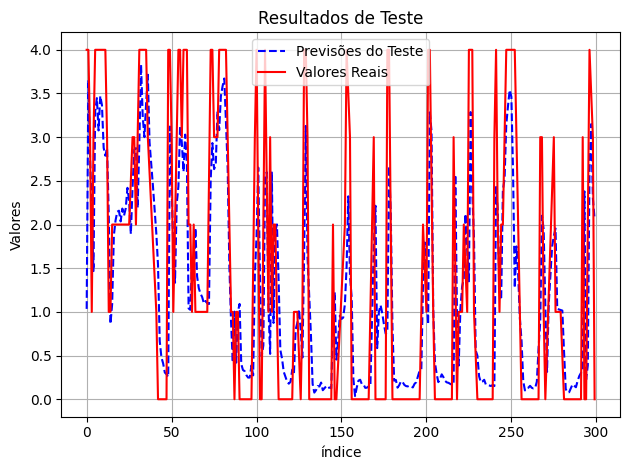

In [46]:
import matplotlib.pyplot as plt

plt.title('Resultados de Teste')
plt.xlabel('índice')
plt.ylabel('Valores')

plt.plot(test_results['Test Predictions'][:300], color='blue', linestyle='--', label='Previsões do Teste')
plt.plot(test_results['Actuals'][:300], color='red', linestyle='-', label='Valores Reais')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
